In [1]:
import yfinance as yf
import joblib
from keras.models import load_model
import pandas as pd
import numpy as np

# Lade die historischen Daten einer Aktie (z.B. Apple)
symbol = "AAPL"  # Apple-Aktien
start_date = "2000-01-01"  # Startdatum für die Daten
end_date = "2024-10-10"    # Enddatum für die Daten

# Daten herunterladen von Yahoo Finance
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
import pandas as pd
import numpy as np
import joblib
from keras.models import load_model
import plotly.express as px
import plotly.graph_objects as go

def trading_simulation(
    df,
    model_path,
    feature_scaler_path,
    target_scaler_path,
    start_date,
    end_date,
    trade_cost=1,
    invest_volume=10,
    buy_threshold=0.5,      # Mindestprozentuale erwartete Rendite zum Kauf (in Prozent)
    sell_threshold=0.5,     # Mindestprozentuale erwartete Rendite zum Verkauf (in Prozent)
    trend_window=5          # Anzahl der Tage zur Berechnung des Trends
):
    """
    Simuliert das Trading basierend auf Modellvorhersagen und berechnet den Gewinn mit Signalfilterung und Trendberücksichtigung.
    Erstellt eine interaktive Plotly-Grafik der realen und vorhergesagten Schlusskurse mit Handelsentscheidungen.

    Parameter:
    df (pd.DataFrame): Originaler DataFrame mit den echten Kursdaten.
    model_path (str): Pfad zur .keras Modell-Datei.
    feature_scaler_path (str): Pfad zur gespeicherten Scaler-Datei für die Eingabefeatures.
    target_scaler_path (str): Pfad zur gespeicherten Scaler-Datei für das Ziel.
    start_date (str): Startdatum der Simulation.
    end_date (str): Enddatum der Simulation.
    trade_cost (float): Kosten für jeden Trade (Kauf und Verkauf).
    invest_volume (float): Investitionsvolumen für jeden Trade.
    buy_threshold (float): Mindestprozentuale erwartete Rendite zum Kauf.
    sell_threshold (float): Mindestprozentuale erwartete Rendite zum Verkauf.
    trend_window (int): Anzahl der Tage zur Berechnung des Trends.

    Rückgabe:
    float: Endkapital nach der Simulation.
    """

    # 1. Scaler laden
    feature_scaler = joblib.load(feature_scaler_path)
    target_scaler = joblib.load(target_scaler_path)
    
    # 2. Modell laden
    model = load_model(model_path, compile=False)
    
    # 3. Überprüfen, ob der Index des DataFrames vom Typ Datum ist
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        print("Konvertiere den Index des DataFrames in Datumsformat...")
        df.index = pd.to_datetime(df.index)
    
    # 4. Filtere die Daten nach dem angegebenen Zeitraum
    df_filtered = df.loc[start_date:end_date].copy()
    
    # 5. Bereite die Eingabedaten vor
    features = df_filtered[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values
    
    # 6. Skaliere die Eingabedaten
    scaled_features = feature_scaler.transform(features)
    
    # 7. Erstelle gefensterte Daten für das LSTM-Modell
    window_size = model.input_shape[1]  # Anzahl der Zeitschritte im Fenster (hier 1)
    X_windowed = []
    for i in range(len(scaled_features) - window_size):
        X_windowed.append(scaled_features[i:i+window_size])
    X_windowed = np.array(X_windowed)
    
    # 8. Modellvorhersagen
    predictions = model.predict(X_windowed)
    
    # 9. Rückskalieren der Vorhersagen
    predictions_rescaled = target_scaler.inverse_transform(predictions)
    
    # Füge die Vorhersagen dem DataFrame hinzu, verschoben um einen Tag nach vorne
    df_filtered = df_filtered.iloc[window_size:].copy()
    df_filtered['Predicted_Close'] = predictions_rescaled.flatten()
    
    # 10. Initialisiere die Variablen für die Simulation
    cash = 1000  # Startkapital in Euro
    stocks = 0   # Anzahl der gehaltenen Aktien
    total_trades = 0  # Gesamtanzahl der Trades
    trades = []  # Liste zur Speicherung der Trades
    
    print(f"Simulation von {start_date} bis {end_date}")
    print(f"Startkapital: {cash}€")
    
    # 11. Berechne den exponentiellen gleitenden Durchschnitt (Trendindikator)
    df_filtered['EMA'] = df_filtered['Close'].ewm(span=trend_window, adjust=False).mean()

    # 12. Durchlaufe die Daten, um Trades basierend auf Vorhersage und Trend durchzuführen
    for i in range(trend_window, len(df_filtered)):
        current_price = df_filtered['Close'].iloc[i - 1]  # Aktueller Tag
        next_prediction = df_filtered['Predicted_Close'].iloc[i - 1]  # Vorhersage für den nächsten Tag
        date = df_filtered.index[i].date()
        
        # Berechne die erwartete prozentuale Rendite
        expected_return = ((next_prediction - current_price) / current_price) * 100
        
        # Berechne den Trend basierend auf den vergangenen trend_window Tagen
        ma_current = df_filtered['EMA'].iloc[i - 1]
        ma_past = df_filtered['EMA'].iloc[i - trend_window - 1] if (i - trend_window - 1) >= 0 else df_filtered['EMA'].iloc[i - 1]
        trend = ma_current - ma_past  # Positive Werte = Aufwärtstrend, negative Werte = Abwärtstrend
        
        # Definiere einen Mindesttrend für Kauf und Verkauf
        trend_threshold = 0  # Kein Mindesttrend, kann angepasst werden
        
        # Kaufentscheidung mit Signalfilterung und Trendberücksichtigung
        if expected_return > buy_threshold and trend > trend_threshold:
            stocks_to_buy = invest_volume / current_price
            if cash >= invest_volume + trade_cost:
                cash -= (invest_volume + trade_cost)
                stocks += stocks_to_buy
                total_trades += 1
                trades.append({
                    'Date': date,
                    'Action': 'Buy',
                    'Stocks': stocks_to_buy,
                    'Price': current_price,
                    'Expected_Return': expected_return,
                    'Trend': 'Up'
                })
                print(f"{date}: Kauf von {stocks_to_buy:.4f} Aktien zu {current_price:.2f}€, "
                      f"erwartete Rendite: {expected_return:.2f}%, Trend: Aufwärts")
            else:
                print(f"{date}: Nicht genügend Kapital für den Kauf.")
        
        # Verkaufsentscheidung mit Signalfilterung und Trendberücksichtigung
        elif expected_return < -sell_threshold and trend < -trend_threshold and stocks > 0:
            sell_value = stocks * current_price
            cash += sell_value - trade_cost
            trades.append({
                'Date': date,
                'Action': 'Sell',
                'Stocks': stocks,
                'Price': current_price,
                'Expected_Return': expected_return,
                'Trend': 'Down'
            })
            print(f"{date}: Verkauf von {stocks:.4f} Aktien zu {current_price:.2f}€, "
                  f"erwartete Rendite: {expected_return:.2f}%, Trend: Abwärts")
            stocks = 0
            total_trades += 1
    
    # 13. Berechne den Wert der verbleibenden Aktien
    final_stock_value = stocks * df_filtered['Close'].iloc[-1]
    total_value = cash + final_stock_value
    
    print(f"\nEndkapital: {total_value:.2f}€ nach {total_trades} Trades.")
    
    # 14. Plotly Express Plot erstellen
    # Erstellen Sie eine Kopie des DataFrames für das Plotting
    plot_df = df_filtered.copy()
    plot_df['Date'] = plot_df.index
    
    # Erstellen Sie Listen der Kauf- und Verkaufspunkte
    buy_trades = [trade for trade in trades if trade['Action'] == 'Buy']
    sell_trades = [trade for trade in trades if trade['Action'] == 'Sell']
    
    # Erstellen Sie den Hauptplot mit den tatsächlichen und vorhergesagten Schlusskursen
    fig = px.line(plot_df, x='Date', y=['Close', 'Predicted_Close'], labels={
        'value': 'Preis (€)',
        'Date': 'Datum',
        'variable': 'Legende'
    }, title='Tatsächlicher vs. Vorhergesagter Schlusskurs mit Handelsentscheidungen')
    
    # Fügen Sie Kaufpunkte hinzu
    if buy_trades:
        buy_dates = [trade['Date'] for trade in buy_trades]
        buy_prices = [trade['Price'] for trade in buy_trades]
        fig.add_trace(go.Scatter(
            x=buy_dates,
            y=buy_prices,
            mode='markers',
            marker=dict(symbol='triangle-up', color='green', size=10),
            name='Käufe'
        ))
    
    # Fügen Sie Verkaufspunkte hinzu
    if sell_trades:
        sell_dates = [trade['Date'] for trade in sell_trades]
        sell_prices = [trade['Price'] for trade in sell_trades]
        fig.add_trace(go.Scatter(
            x=sell_dates,
            y=sell_prices,
            mode='markers',
            marker=dict(symbol='triangle-down', color='red', size=10),
            name='Verkäufe'
        ))

    # Fügen Sie die EMA-Linie hinzu
    fig.add_trace(go.Scatter(
        x=plot_df['Date'], 
        y=plot_df['EMA'], 
        mode='lines', 
        name='EMA (Gleitender Durchschnitt)', 
        line=dict(color='orange')
    ))
    
    # Aktualisieren Sie das Layout für bessere Lesbarkeit
    fig.update_layout(
        xaxis_title='Datum',
        yaxis_title='Preis (€)',
        legend_title='Legende',
        template='plotly_dark'
    )
    
    # Anzeigen des Plots
    fig.show()
    
    return total_value


/Users/jonas/.local/share/virtualenvs/Jupyter-K0eqoyk3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



11/11 [==============================] - 0s 443us/step
Simulation von 2023-06-10 bis 2024-10-10
Startkapital: 1000€
2023-08-07: Kauf von 0.1099 Aktien zu 181.99€, erwartete Rendite: 4.70%, Trend: Aufwärts
2023-08-08: Kauf von 0.1118 Aktien zu 178.85€, erwartete Rendite: 2.67%, Trend: Aufwärts
2024-01-03: Kauf von 0.1077 Aktien zu 185.64€, erwartete Rendite: 3.60%, Trend: Aufwärts
2024-05-24: Kauf von 0.1070 Aktien zu 186.88€, erwartete Rendite: 2.19%, Trend: Aufwärts
2024-08-06: Kauf von 0.0956 Aktien zu 209.27€, erwartete Rendite: 4.25%, Trend: Aufwärts

Endkapital: 1017.13€ nach 5 Trades.


/Users/jonas/.local/share/virtualenvs/Jupyter-K0eqoyk3/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/jonas/.local/share/virtualenvs/Jupyter-K0eqoyk3/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



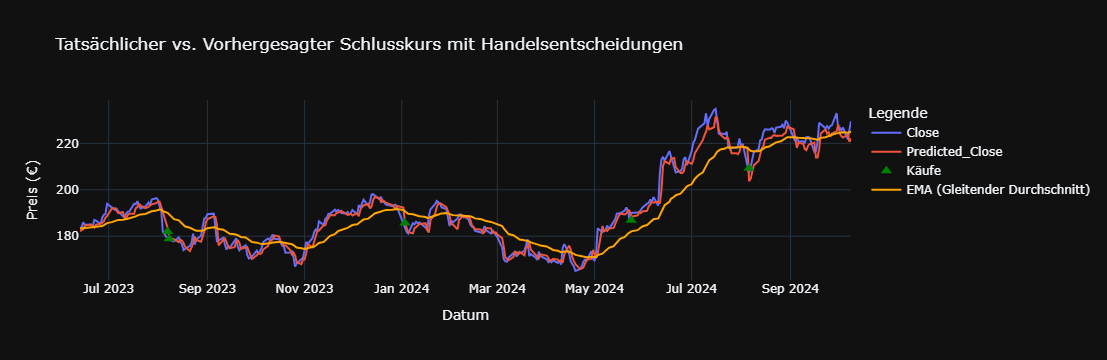

1017.1262838832475

In [12]:
trading_simulation(df, 
                   model_path="./models/model_20241011-171432_ws1_bs5_epochs30_units64_layers1.keras", 
                   feature_scaler_path="./scaler/feature_scaler.pkl",
                   target_scaler_path="./scaler/target_scaler.pkl",
                   start_date="2023-06-10", end_date="2024-10-10", 
                   trade_cost=1, 
                   invest_volume=20,
                   buy_threshold=2.0,   
                   sell_threshold=10.8,
                   trend_window=30)